In [1]:
import os
import mysql.connector
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Electricity price Predection of 2020 - 2023

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,explained_variance_score

In [4]:
# Connection for MySQL server
config = {
  'user': 'root',
  'password': 'root',
  'host': 'localhost',
  'database': 'electric_predict',
    'port':'3308',
    'auth_plugin':"mysql_native_password"
}

In [5]:
mysql_connection = mysql.connector.connect(**config)

## Import the Market price, Demand data, Sysem sell and Energy source

In [6]:
# import market price data
market_data = pd.read_sql("SELECT * FROM `market$price$data_new`   WHERE MARKET_INDEX_DATA_PROVIDER != 'N2EXMIDP'  and MARKET_INDEX_PRICE > 0 and settlement_date >= '2020-01-01 00:00:00'", con=mysql_connection)

In [7]:
#imported the demand data
demand_data = pd.read_sql(" SELECT * FROM demanddata2 where SETTLEMENT_DATE >= '2020-01-01 00:00:00'", con=mysql_connection)

In [8]:
# imported the energry source generation data
energy_source = pd.read_sql(" SELECT * FROM df_fuel_ckan where DATE_TIME >='2020-01-01 00:00:00'", con=mysql_connection)

In [9]:
#imported the system sell data
systemSell=pd.read_excel('D:\Project\SellBuyDataSet/SystemSell.xlsx')

In [10]:
sbp_start =pd.to_datetime('01-01-2020',infer_datetime_format=True)
sbp_end = pd.to_datetime('31-12-2019',infer_datetime_format=True)
#SSP2New = systemSell[(systemSell['Date'] >= sbp_start) & (systemSell['Date'] <= sbp_end)]

## Fetched data for 2020 -2023

In [11]:
SSP2New = systemSell[(systemSell['Date'] >= sbp_start)]

In [12]:
# removed the SSP daily Average column
systemSella=SSP2New.drop(columns=['SSP Daily Average (£/Mwh)','Run'],axis=1)

In [13]:
SSPa= systemSella.melt(id_vars='Date',var_name= 'Settlement_Period',value_name='System Sell Price')

sell_data = SSPa.sort_values(by=['Date', 'Settlement_Period']).reset_index(drop=True)

In [14]:
print(len(market_data),len(demand_data),len(energy_source), len(sell_data))

59758 58654 60741 59616


In [15]:
market_data

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,MARKET_INDEX_DATA_PROVIDER,MARKET_INDEX_VOLUME,MARKET_INDEX_PRICE
0,2020-01-01,1,APXMIDP,785,35
1,2020-01-01,2,APXMIDP,636,37
2,2020-01-01,3,APXMIDP,741,38
3,2020-01-01,4,APXMIDP,619,36
4,2020-01-01,5,APXMIDP,695,32
...,...,...,...,...,...
59753,2023-06-14,44,APXMIDP,1470,106
59754,2023-06-14,45,APXMIDP,1624,110
59755,2023-06-14,46,APXMIDP,1856,99
59756,2023-06-14,47,APXMIDP,859,118


In [16]:
demand_data

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW
0,2020-01-01,1,26340,27153,23821,1244,6465,0,13080,0,15,1703,0,852,-151,-47,854,0,0
1,2020-01-01,2,26921,27684,24393,1188,6465,0,13080,0,17,1703,0,853,-146,0,854,0,0
2,2020-01-01,3,26569,27240,24085,1156,6465,0,13080,0,18,1703,0,852,-53,0,854,0,0
3,2020-01-01,4,25754,26435,23350,1125,6465,0,13080,0,15,1703,0,852,-66,0,854,0,0
4,2020-01-01,5,25075,25824,22788,1106,6465,0,13080,0,15,1704,0,853,-74,-60,854,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58649,2023-05-06,44,25789,27096,23419,787,6545,0,13080,0,6,1404,468,364,-442,-359,88,1296,857
58650,2023-05-06,45,24689,25891,22388,774,6545,0,13080,0,6,1073,235,111,-424,-244,-28,1296,713
58651,2023-05-06,46,23501,24673,21286,761,6545,0,13080,0,11,1071,235,103,-452,-183,-26,1302,707
58652,2023-05-06,47,22568,23757,20460,752,6545,0,13080,0,12,1772,793,538,-452,-225,554,1387,874


In [17]:
energy_source

,DATE_TIME,GAS,COAL,NUCLEAR,WIND,HYDRO,BIOMASS,OTHER,SOLAR,STORAGE,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2020-01-01 00:00:00+00,7915,670,6953,6141,672,2984,2353,130,0,...,2.4,10.7,8.4,0.5,0,0.1,100,57.9,49.4,24.5
1,2020-01-01 00:30:00+00,8423,670,6949,6142,669,2934,2358,123,0,...,2.4,10.4,8.3,0.4,0,0.2,100,56.9,48.6,24
2,2020-01-01 01:00:00+00,8040,670,6952,6090,662,2884,2356,122,0,...,2.4,10.4,8.5,0.4,0,0,100,57.8,49.3,24.3
3,2020-01-01 01:30:00+00,7502,670,6948,5851,591,2834,2343,122,0,...,2.2,10.6,8.7,0.5,0,0,100,58.6,49.8,24
4,2020-01-01 02:00:00+00,7023,669,6954,5689,548,2780,2356,121,0,...,2.1,10.6,9,0.5,0,0,100,59.5,50.5,23.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60736,2023-06-19 08:00:00+00,12491,0,3569,8482,114,2634,736,171,4310,...,0.4,8.1,2.3,0.5,13.3,0,100,52.9,50.7,39.7
60737,2023-06-19 08:30:00+00,12333,0,3585,8446,90,2196,762,177,4893,...,0.3,6.8,2.3,0.5,15.1,0,100,54.7,52.4,41.3
60738,2023-06-19 09:00:00+00,12255,0,3596,8207,80,2152,761,258,5449,...,0.2,6.6,2.3,0.8,16.6,0.1,100,55.2,52.9,41.9
60739,2023-06-19 09:30:00+00,12285,0,3601,8019,80,1878,755,187,5961,...,0.2,5.7,2.3,0.6,18.1,0.2,100,56.1,53.8,42.8


In [18]:
sell_data

,Date,Settlement_Period,System Sell Price
0,2020-01-01,1,50.90
1,2020-01-01,2,51.00
2,2020-01-01,3,29.37
3,2020-01-01,4,28.52
4,2020-01-01,5,25.78
...,...,...,...
59611,2023-05-26,44,119.00
59612,2023-05-26,45,119.00
59613,2023-05-26,46,43.00
59614,2023-05-26,47,114.00


In [19]:
#Converted DATE_TIME in the datetime formate
energy_source['DATE_TIME']=pd.to_datetime(energy_source['DATE_TIME'])

In [20]:
# Remove the timezone information from the datetime column
energy_source['DATE_TIME'] = energy_source['DATE_TIME'].dt.tz_localize(None)

In [21]:
energy_source

,DATE_TIME,GAS,COAL,NUCLEAR,WIND,HYDRO,BIOMASS,OTHER,SOLAR,STORAGE,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2020-01-01 00:00:00,7915,670,6953,6141,672,2984,2353,130,0,...,2.4,10.7,8.4,0.5,0,0.1,100,57.9,49.4,24.5
1,2020-01-01 00:30:00,8423,670,6949,6142,669,2934,2358,123,0,...,2.4,10.4,8.3,0.4,0,0.2,100,56.9,48.6,24
2,2020-01-01 01:00:00,8040,670,6952,6090,662,2884,2356,122,0,...,2.4,10.4,8.5,0.4,0,0,100,57.8,49.3,24.3
3,2020-01-01 01:30:00,7502,670,6948,5851,591,2834,2343,122,0,...,2.2,10.6,8.7,0.5,0,0,100,58.6,49.8,24
4,2020-01-01 02:00:00,7023,669,6954,5689,548,2780,2356,121,0,...,2.1,10.6,9,0.5,0,0,100,59.5,50.5,23.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60736,2023-06-19 08:00:00,12491,0,3569,8482,114,2634,736,171,4310,...,0.4,8.1,2.3,0.5,13.3,0,100,52.9,50.7,39.7
60737,2023-06-19 08:30:00,12333,0,3585,8446,90,2196,762,177,4893,...,0.3,6.8,2.3,0.5,15.1,0,100,54.7,52.4,41.3
60738,2023-06-19 09:00:00,12255,0,3596,8207,80,2152,761,258,5449,...,0.2,6.6,2.3,0.8,16.6,0.1,100,55.2,52.9,41.9
60739,2023-06-19 09:30:00,12285,0,3601,8019,80,1878,755,187,5961,...,0.2,5.7,2.3,0.6,18.1,0.2,100,56.1,53.8,42.8


In [22]:
demand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58654 entries, 0 to 58653
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   SETTLEMENT_DATE            58654 non-null  datetime64[ns]
 1   SETTLEMENT_PERIOD          58654 non-null  int64         
 2   ND                         58654 non-null  int64         
 3   TSD                        58654 non-null  int64         
 4   ENGLAND_WALES_DEMAND       58654 non-null  int64         
 5   EMBEDDED_WIND_GENERATION   58654 non-null  int64         
 6   EMBEDDED_WIND_CAPACITY     58654 non-null  int64         
 7   EMBEDDED_SOLAR_GENERATION  58654 non-null  int64         
 8   EMBEDDED_SOLAR_CAPACITY    58654 non-null  int64         
 9   NON_BM_STOR                58654 non-null  int64         
 10  PUMP_STORAGE_PUMPING       58654 non-null  int64         
 11  IFA_FLOW                   58654 non-null  int64         
 12  IFA2

In [23]:
demand_data['SETTLEMENT_DATE']=demand_data['SETTLEMENT_DATE'].astype(str)
demand_data['SETTLEMENT_PERIOD']=pd.to_numeric(demand_data['SETTLEMENT_PERIOD'],errors='coerce').astype('Int64')

In [24]:
from datetime import datetime
demand_data['date']=demand_data['SETTLEMENT_DATE'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
demand_data['Time Interval'] = (demand_data['SETTLEMENT_PERIOD']-1) * 30

In [25]:


demand_data['date'] = demand_data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
import datetime
demand_data['Time Format'] = demand_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [26]:
demand_data['Time Format'] = demand_data['Time Format'].apply(lambda x: x.strftime('%H:%M:%S'))
demand_data['DATETIME'] = pd.to_datetime(demand_data['date'] + ' ' + demand_data['Time Format'])
demand_data['Time Format'] = demand_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [27]:
demand_data2 =demand_data.groupby('DATETIME').agg({'SETTLEMENT_PERIOD': 'first',
                                                   'TSD': 'sum', 
                                                   'EMBEDDED_WIND_GENERATION': 'sum',
                                                   'EMBEDDED_WIND_CAPACITY': 'sum',  
                                                   'EMBEDDED_SOLAR_GENERATION': 'sum',  
                                                   'EMBEDDED_SOLAR_CAPACITY': 'sum',  
                                                   'ND': 'sum'}).reset_index()

In [28]:
demand_data2

,DATETIME,SETTLEMENT_PERIOD,TSD,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,ND
0,2020-01-01 00:00:00,1,27153,1244,6465,0,13080,26340
1,2020-01-01 00:30:00,2,27684,1188,6465,0,13080,26921
2,2020-01-01 01:00:00,3,27240,1156,6465,0,13080,26569
3,2020-01-01 01:30:00,4,26435,1125,6465,0,13080,25754
4,2020-01-01 02:00:00,5,25824,1106,6465,0,13080,25075
...,...,...,...,...,...,...,...,...
58643,2023-05-06 21:30:00,44,27096,787,6545,0,13080,25789
58644,2023-05-06 22:00:00,45,25891,774,6545,0,13080,24689
58645,2023-05-06 22:30:00,46,24673,761,6545,0,13080,23501
58646,2023-05-06 23:00:00,47,23757,752,6545,0,13080,22568


In [29]:
market_data['SETTLEMENT_DATE']=market_data['SETTLEMENT_DATE'].astype(str)
market_data['SETTLEMENT_PERIOD']=pd.to_numeric(market_data['SETTLEMENT_PERIOD'],errors='coerce').astype('Int64')

In [30]:
from datetime import datetime
market_data['date']=market_data['SETTLEMENT_DATE'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
market_data['Time Interval'] = (market_data['SETTLEMENT_PERIOD']-1) * 30

In [31]:
market_data['date'] =pd.to_datetime(market_data['date'])

In [32]:

market_data['date'] = market_data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
import datetime
market_data['Time Format'] = market_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [33]:
market_data['Time Format'] = market_data['Time Format'].apply(lambda x: x.strftime('%H:%M:%S'))
market_data['DATETIME'] = pd.to_datetime(market_data['date'] + ' ' + market_data['Time Format'])
market_data['Time Format'] = market_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [34]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59758 entries, 0 to 59757
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   SETTLEMENT_DATE             59758 non-null  object        
 1   SETTLEMENT_PERIOD           59758 non-null  Int64         
 2   MARKET_INDEX_DATA_PROVIDER  59758 non-null  object        
 3   MARKET_INDEX_VOLUME         59758 non-null  int64         
 4   MARKET_INDEX_PRICE          59758 non-null  int64         
 5   date                        59758 non-null  object        
 6   Time Interval               59758 non-null  Int64         
 7   Time Format                 59758 non-null  object        
 8   DATETIME                    59758 non-null  datetime64[ns]
dtypes: Int64(2), datetime64[ns](1), int64(2), object(4)
memory usage: 4.2+ MB


In [35]:
market_data2 =market_data.groupby('DATETIME').agg({'SETTLEMENT_PERIOD': 'first',
                                                   'MARKET_INDEX_VOLUME': 'sum', 
                                                   'MARKET_INDEX_PRICE': 'sum',
                                                   }).reset_index()

In [36]:
market_data2

,DATETIME,SETTLEMENT_PERIOD,MARKET_INDEX_VOLUME,MARKET_INDEX_PRICE
0,2020-01-01 00:00:00,1,785,35
1,2020-01-01 00:30:00,2,636,37
2,2020-01-01 01:00:00,3,741,38
3,2020-01-01 01:30:00,4,619,36
4,2020-01-01 02:00:00,5,695,32
...,...,...,...,...
59748,2023-06-14 21:30:00,44,1470,106
59749,2023-06-14 22:00:00,45,1624,110
59750,2023-06-14 22:30:00,46,1856,99
59751,2023-06-14 23:00:00,47,859,118


In [37]:
sell_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59616 entries, 0 to 59615
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               59616 non-null  datetime64[ns]
 1   Settlement_Period  59616 non-null  object        
 2   System Sell Price  59608 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ MB


In [38]:
sell_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59616 entries, 0 to 59615
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               59616 non-null  datetime64[ns]
 1   Settlement_Period  59616 non-null  object        
 2   System Sell Price  59608 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ MB


In [39]:
sell_data['Date']=sell_data['Date'].astype(str)
sell_data['Settlement_Period']=pd.to_numeric(sell_data['Settlement_Period'],errors='coerce').astype('Int64')

In [40]:
sell_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59616 entries, 0 to 59615
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               59616 non-null  object 
 1   Settlement_Period  59616 non-null  Int64  
 2   System Sell Price  59608 non-null  float64
dtypes: Int64(1), float64(1), object(1)
memory usage: 1.4+ MB


In [42]:
from datetime import datetime
sell_data['date']=sell_data['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
sell_data['Time Interval'] = (sell_data['Settlement_Period']-1) * 30

sell_data['date'] = sell_data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
import datetime
sell_data['Time Format'] = sell_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [43]:
sell_data['Time Format'] = sell_data['Time Format'].apply(lambda x: x.strftime('%H:%M:%S'))
sell_data['DATETIME'] = pd.to_datetime(market_data['date'] + ' ' + sell_data['Time Format'])
sell_data['Time Format'] = sell_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [44]:
sell_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59616 entries, 0 to 59615
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               59616 non-null  object        
 1   Settlement_Period  59616 non-null  Int64         
 2   System Sell Price  59608 non-null  float64       
 3   date               59616 non-null  object        
 4   Time Interval      59616 non-null  Int64         
 5   Time Format        59616 non-null  object        
 6   DATETIME           59616 non-null  datetime64[ns]
dtypes: Int64(2), datetime64[ns](1), float64(1), object(3)
memory usage: 3.3+ MB


In [45]:
sell_data2 = sell_data.groupby('DATETIME').agg({'Settlement_Period': 'first',
                                                   'System Sell Price': 'sum', 
                                                  }).reset_index()

In [46]:
sell_data2

,DATETIME,Settlement_Period,System Sell Price
0,2020-01-01 00:00:00,1,50.90
1,2020-01-01 00:30:00,2,51.00
2,2020-01-01 01:00:00,3,29.37
3,2020-01-01 01:30:00,4,28.52
4,2020-01-01 02:00:00,5,25.78
...,...,...,...
59607,2023-06-11 22:30:00,46,43.00
59608,2023-06-11 23:00:00,47,53.25
59609,2023-06-11 23:30:00,48,51.60
59610,2023-06-12 23:00:00,47,114.00


## Merging the System sell data with Market Index Data

In [47]:
predict_df1 = pd.merge(sell_data2, market_data2, on='DATETIME', how='inner')

In [48]:
len(predict_df1)

59017

In [49]:
energy_source

,DATE_TIME,GAS,COAL,NUCLEAR,WIND,HYDRO,BIOMASS,OTHER,SOLAR,STORAGE,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2020-01-01 00:00:00,7915,670,6953,6141,672,2984,2353,130,0,...,2.4,10.7,8.4,0.5,0,0.1,100,57.9,49.4,24.5
1,2020-01-01 00:30:00,8423,670,6949,6142,669,2934,2358,123,0,...,2.4,10.4,8.3,0.4,0,0.2,100,56.9,48.6,24
2,2020-01-01 01:00:00,8040,670,6952,6090,662,2884,2356,122,0,...,2.4,10.4,8.5,0.4,0,0,100,57.8,49.3,24.3
3,2020-01-01 01:30:00,7502,670,6948,5851,591,2834,2343,122,0,...,2.2,10.6,8.7,0.5,0,0,100,58.6,49.8,24
4,2020-01-01 02:00:00,7023,669,6954,5689,548,2780,2356,121,0,...,2.1,10.6,9,0.5,0,0,100,59.5,50.5,23.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60736,2023-06-19 08:00:00,12491,0,3569,8482,114,2634,736,171,4310,...,0.4,8.1,2.3,0.5,13.3,0,100,52.9,50.7,39.7
60737,2023-06-19 08:30:00,12333,0,3585,8446,90,2196,762,177,4893,...,0.3,6.8,2.3,0.5,15.1,0,100,54.7,52.4,41.3
60738,2023-06-19 09:00:00,12255,0,3596,8207,80,2152,761,258,5449,...,0.2,6.6,2.3,0.8,16.6,0.1,100,55.2,52.9,41.9
60739,2023-06-19 09:30:00,12285,0,3601,8019,80,1878,755,187,5961,...,0.2,5.7,2.3,0.6,18.1,0.2,100,56.1,53.8,42.8


In [50]:
energy_source.rename(columns={'DATE_TIME':'DATETIME'},inplace=True)

In [51]:
energy_source

,DATETIME,GAS,COAL,NUCLEAR,WIND,HYDRO,BIOMASS,OTHER,SOLAR,STORAGE,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2020-01-01 00:00:00,7915,670,6953,6141,672,2984,2353,130,0,...,2.4,10.7,8.4,0.5,0,0.1,100,57.9,49.4,24.5
1,2020-01-01 00:30:00,8423,670,6949,6142,669,2934,2358,123,0,...,2.4,10.4,8.3,0.4,0,0.2,100,56.9,48.6,24
2,2020-01-01 01:00:00,8040,670,6952,6090,662,2884,2356,122,0,...,2.4,10.4,8.5,0.4,0,0,100,57.8,49.3,24.3
3,2020-01-01 01:30:00,7502,670,6948,5851,591,2834,2343,122,0,...,2.2,10.6,8.7,0.5,0,0,100,58.6,49.8,24
4,2020-01-01 02:00:00,7023,669,6954,5689,548,2780,2356,121,0,...,2.1,10.6,9,0.5,0,0,100,59.5,50.5,23.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60736,2023-06-19 08:00:00,12491,0,3569,8482,114,2634,736,171,4310,...,0.4,8.1,2.3,0.5,13.3,0,100,52.9,50.7,39.7
60737,2023-06-19 08:30:00,12333,0,3585,8446,90,2196,762,177,4893,...,0.3,6.8,2.3,0.5,15.1,0,100,54.7,52.4,41.3
60738,2023-06-19 09:00:00,12255,0,3596,8207,80,2152,761,258,5449,...,0.2,6.6,2.3,0.8,16.6,0.1,100,55.2,52.9,41.9
60739,2023-06-19 09:30:00,12285,0,3601,8019,80,1878,755,187,5961,...,0.2,5.7,2.3,0.6,18.1,0.2,100,56.1,53.8,42.8


## Merging Energy source and Demand Data

In [52]:
predict_df2 = pd.merge(energy_source, demand_data2, on='DATETIME', how='inner')

In [53]:
len(predict_df2)

58648

## Merging Market data, Energy source, Demand and System Sell Data

In [54]:
predict_final = pd.merge(predict_df1, predict_df2, on='DATETIME', how='inner')

In [55]:
len(predict_final)

57317

## Correlation Between Demand Data , System Price and Market Index Value

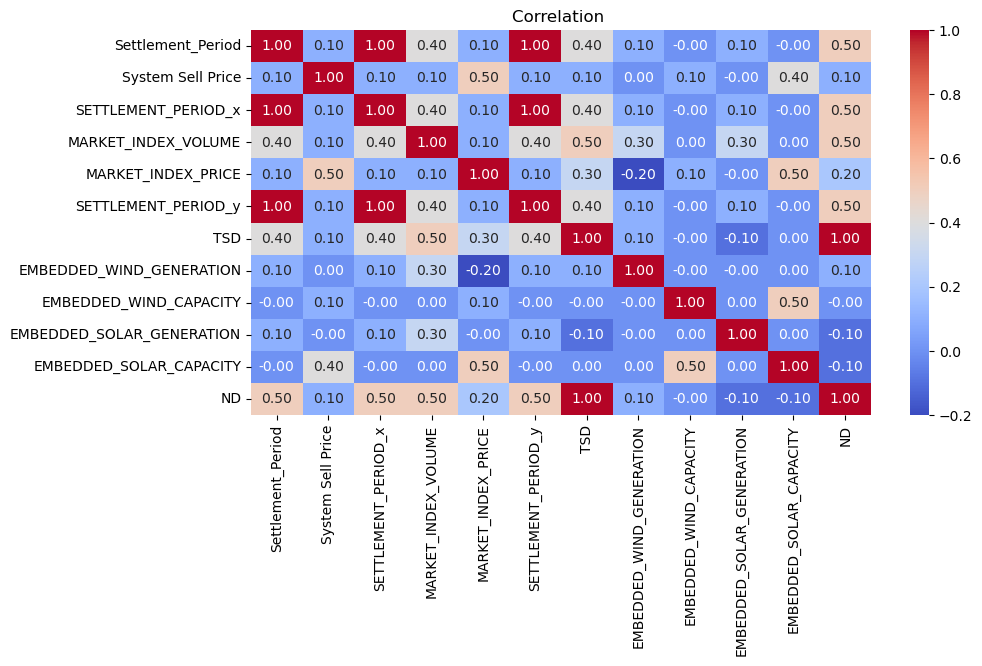

In [56]:
correlation_matrix = predict_final.corr()

#  heatmap correlation
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix.round(1), annot=True, cmap="coolwarm",fmt=".2f")
plt.title('Correlation ')
plt.show()

In [57]:
predict_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57317 entries, 0 to 57316
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DATETIME                   57317 non-null  datetime64[ns]
 1   Settlement_Period          57317 non-null  Int64         
 2   System Sell Price          57317 non-null  float64       
 3   SETTLEMENT_PERIOD_x        57317 non-null  Int64         
 4   MARKET_INDEX_VOLUME        57317 non-null  int64         
 5   MARKET_INDEX_PRICE         57317 non-null  int64         
 6   GAS                        57317 non-null  object        
 7   COAL                       57317 non-null  object        
 8   NUCLEAR                    57317 non-null  object        
 9   WIND                       57317 non-null  object        
 10  HYDRO                      57317 non-null  object        
 11  BIOMASS                    57317 non-null  object        
 12  OTHE

In [58]:
#Changing data type
predict_final['HYDRO_perc']=predict_final['HYDRO_perc'].astype(float)
predict_final['WIND_perc']=predict_final['WIND_perc'].astype(float)
predict_final['SOLAR_perc']=predict_final['SOLAR_perc'].astype(float)

In [59]:
predict_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57317 entries, 0 to 57316
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DATETIME                   57317 non-null  datetime64[ns]
 1   Settlement_Period          57317 non-null  Int64         
 2   System Sell Price          57317 non-null  float64       
 3   SETTLEMENT_PERIOD_x        57317 non-null  Int64         
 4   MARKET_INDEX_VOLUME        57317 non-null  int64         
 5   MARKET_INDEX_PRICE         57317 non-null  int64         
 6   GAS                        57317 non-null  object        
 7   COAL                       57317 non-null  object        
 8   NUCLEAR                    57317 non-null  object        
 9   WIND                       57317 non-null  object        
 10  HYDRO                      57317 non-null  object        
 11  BIOMASS                    57317 non-null  object        
 12  OTHE

## Finala Prediction Variables

In [60]:
predict_final.head()

,DATETIME,Settlement_Period,System Sell Price,SETTLEMENT_PERIOD_x,MARKET_INDEX_VOLUME,MARKET_INDEX_PRICE,GAS,COAL,NUCLEAR,WIND,...,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc,SETTLEMENT_PERIOD_y,TSD,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,ND
0,2020-01-01 00:00:00,1,50.90,1,785,35,7915,670,6953,6141,...,57.9,49.4,24.5,1,27153,1244,6465,0,13080,26340
1,2020-01-01 00:30:00,2,51.00,2,636,37,8423,670,6949,6142,...,56.9,48.6,24,2,27684,1188,6465,0,13080,26921
2,2020-01-01 01:00:00,3,29.37,3,741,38,8040,670,6952,6090,...,57.8,49.3,24.3,3,27240,1156,6465,0,13080,26569
3,2020-01-01 01:30:00,4,28.52,4,619,36,7502,670,6948,5851,...,58.6,49.8,24,4,26435,1125,6465,0,13080,25754
4,2020-01-01 02:00:00,5,25.78,5,695,32,7023,669,6954,5689,...,59.5,50.5,23.9,5,25824,1106,6465,0,13080,25075


## Splitting Independent Variable Dependent Variable

In [61]:
y = predict_final['MARKET_INDEX_PRICE'].copy()
X = predict_final[['MARKET_INDEX_VOLUME','TSD','System Sell Price','EMBEDDED_WIND_GENERATION','EMBEDDED_WIND_CAPACITY','HYDRO_perc','WIND_perc','SOLAR_perc']]

In [102]:
pf2=predict_final[['MARKET_INDEX_PRICE','MARKET_INDEX_VOLUME','TSD','System Sell Price','EMBEDDED_WIND_GENERATION','EMBEDDED_WIND_CAPACITY','HYDRO_perc','WIND_perc','SOLAR_perc']]

##  heatmap correlation for Predection

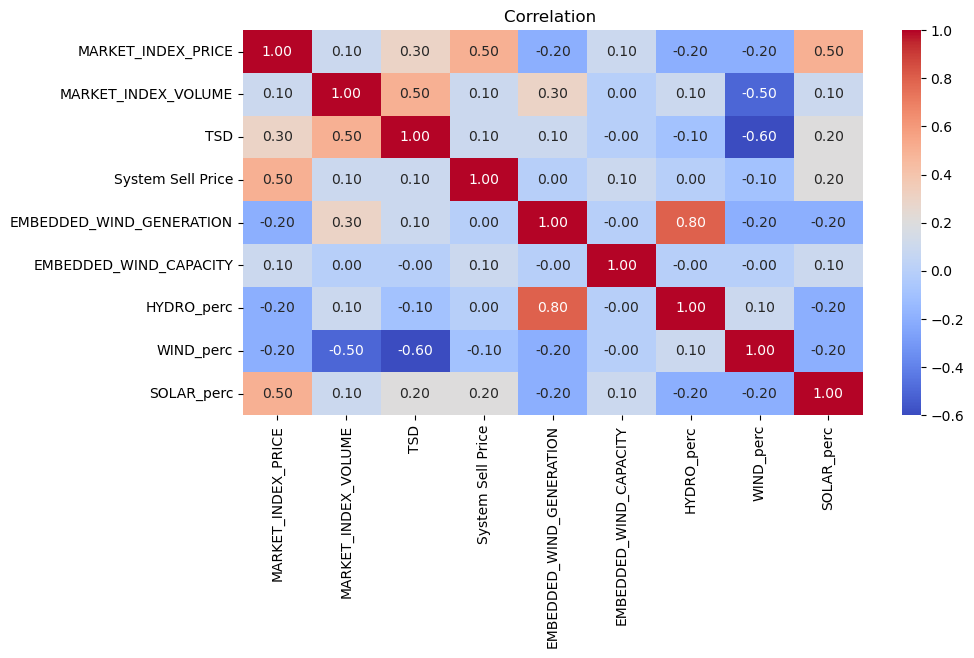

In [103]:
correlation_matrix = pf2.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix.round(1), annot=True, cmap="coolwarm",fmt=".2f")
plt.title('Correlation ')
plt.show()

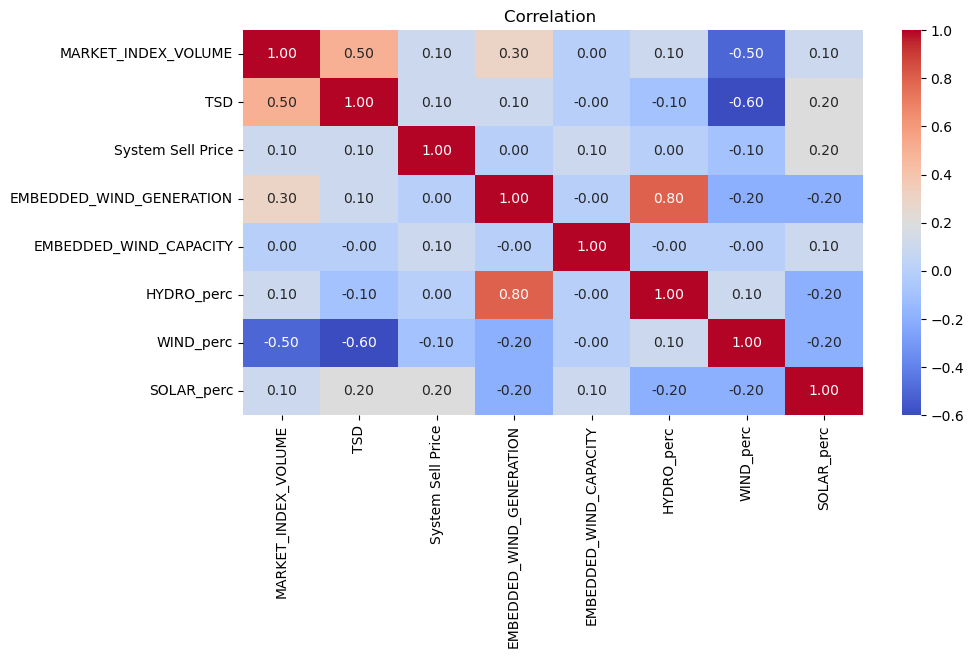

In [62]:
#  heatmap correlation for Independent Variable
correlation_matrix = X.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix.round(1), annot=True, cmap="coolwarm",fmt=".2f")
plt.title('Correlation ')
plt.show()

## Linear Regression Predection

In [63]:
sc = StandardScaler()

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

In [65]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [66]:
mlr = LinearRegression()  
mlr.fit(X_train, y_train)

LinearRegression()

In [67]:
y_pred_mlr= mlr.predict(X_test)

In [68]:
print("r2 score: %.10f" % r2_score(y_test, y_pred_mlr))
print("explained variance score: %.10f" % explained_variance_score(y_test, y_pred_mlr))
print("mae: %.10f" % mean_absolute_error(y_test, y_pred_mlr))
print("mse: %.10f" % mean_squared_error(y_test, y_pred_mlr))
print("rmse: %.10f" % mean_squared_error(y_test, y_pred_mlr,squared = False))

r2 score: 0.4284391149
explained variance score: 0.4284394060
mae: 51.3638045907
mse: 5505.0834004884
rmse: 74.1962492346


## Random Forest Regression Prediction

In [69]:
r2_lr=r2_score(y_test, y_pred_mlr)
mae_lr= mean_absolute_error(y_test, y_pred_mlr)
mse_lr= mean_squared_error(y_test, y_pred_mlr)
rmse_lr=mean_squared_error(y_test, y_pred_mlr,squared = False)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [71]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [72]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [73]:
y_pred_rf = rf_model.predict(X_test)

In [74]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf= mean_absolute_error(y_test, y_pred_rf)
#mse_rf= mean_squared_error(y_test, y_pred_rf)
rmse_rf=mean_squared_error(y_test, y_pred_rf,squared = False)

r2_rf = r2_score(y_test, y_pred_rf)

In [75]:
print("r2 score: %.10f" % r2_score(y_test, y_pred_rf))
print("explained variance score: %.10f" % explained_variance_score(y_test, y_pred_rf))
print("mae: %.10f" % mean_absolute_error(y_test, y_pred_rf))
print("mse: %.10f" % mean_squared_error(y_test, y_pred_rf))
print("rmse: %.10f" % mean_squared_error(y_test, y_pred_rf,squared = False))

r2 score: 0.7988459258
explained variance score: 0.7988672579
mae: 23.8880268667
mse: 2039.9647486043
rmse: 45.1659689213


In [76]:
data_rf = y_pred_rf.reshape(-1)

In [77]:
rf_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': data_rf})

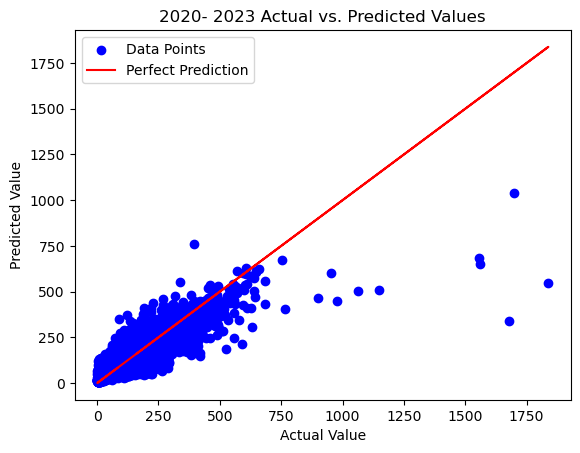

In [78]:
plt.scatter(rf_diff['Actual value'], rf_diff['Predicted value'], color='blue', label='Data Points')
plt.plot(rf_diff['Actual value'], rf_diff['Actual value'], color='red', label='Perfect Prediction')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('2020- 2023 Actual vs. Predicted Values')
plt.legend()
plt.show()

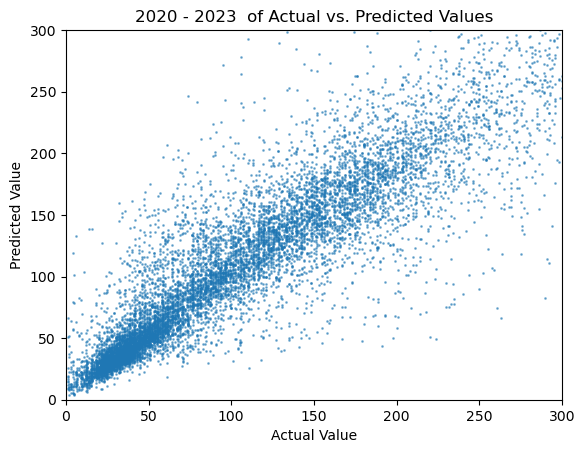

In [79]:
plt.scatter(rf_diff['Actual value'], rf_diff['Predicted value'],s=1, alpha=0.5)

# Add labels and title
x_min=0
x_max=300

y_min=0
y_max=300
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('2020 - 2023  of Actual vs. Predicted Values')

# Display the plot
plt.show()

## Random Forest Predicted and Actual Value

In [80]:
rf_diff.head(100)

,Actual value,Predicted value
56552,82,96.00
2449,38,40.69
38733,200,184.38
6793,13,25.86
13082,53,46.85
...,...,...
35815,176,156.10
33296,224,196.59
11670,68,63.41
19077,84,87.88


## ANN

In [86]:
from sklearn.metrics import accuracy_score

In [82]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [83]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [84]:
model_ann = Sequential()

 #input layer
model_ann.add(Dense(units=8, activation='relu', input_shape=(X_train.shape[1],)))

#hidden layers
model_ann.add(Dense(units=4, activation='relu'))
model_ann.add(Dropout(0.2))
model_ann.add(Dense(units=4, activation='relu'))
model_ann.add(Dropout(0.2))
#output layer
model_ann.add(Dense(units=1, activation='linear'))

# Compile the model
model_ann.compile(loss='mean_squared_error', optimizer='adam')

### Tranined model with Epochs 50

In [87]:
batch_size = 42
epochs = 50
model_ann.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/50
874/874 [==============================] - 5s 3ms/step - loss: 4824749.5000 - val_loss: 11114.3838
Epoch 2/50
874/874 [==============================] - 3s 3ms/step - loss: 152649.1250 - val_loss: 10769.3398
Epoch 3/50
874/874 [==============================] - 3s 3ms/step - loss: 30393.4961 - val_loss: 11085.2344
Epoch 4/50
874/874 [==============================] - 3s 3ms/step - loss: 14200.6641 - val_loss: 10491.8623
Epoch 5/50
874/874 [==============================] - 3s 3ms/step - loss: 12948.1973 - val_loss: 10419.3828
Epoch 6/50
874/874 [==============================] - 3s 3ms/step - loss: 12863.4023 - val_loss: 10319.7705
Epoch 7/50
874/874 [==============================] - 3s 3ms/step - loss: 12603.0928 - val_loss: 10514.4014
Epoch 8/50
874/874 [==============================] - 3s 3ms/step - loss: 12562.2246 - val_loss: 10612.5088
Epoch 9/50
874/874 [==============================] - 3s 3ms/step - loss: 12552.5781 - val_loss: 10355.7529
Epoch 10/50
874/874 [====

In [88]:
y_pred_ann = model_ann.predict(X_test)

print("r2 score: %.10f" % r2_score(y_test, y_pred_ann))
print("explained variance score: %.10f" % explained_variance_score(y_test, y_pred_ann))
print("mae: %.10f" % mean_absolute_error(y_test, y_pred_ann))
print("mse: %.10f" % mean_squared_error(y_test, y_pred_ann))
print("rmse: %.10f" % mean_squared_error(y_test, y_pred_ann,squared = False))

359/359 [==============================] - 1s 2ms/step
r2 score: 0.4122160613
explained variance score: 0.4591413940
mae: 44.2505643358
mse: 5960.8959908959
rmse: 77.2068390163


In [98]:
y_pred_ann = model_ann.predict(X_test)

print("r2 score: %.10f" % r2_score(y_test, y_pred_ann))
print("explained variance score: %.10f" % explained_variance_score(y_test, y_pred_ann))
print("mae: %.10f" % mean_absolute_error(y_test, y_pred_ann))
print("mse: %.10f" % mean_squared_error(y_test, y_pred_ann))
print("rmse: %.10f" % mean_squared_error(y_test, y_pred_ann,squared = False))

359/359 [==============================] - 1s 2ms/step
r2 score: 0.4122160613
explained variance score: 0.4591413940
mae: 44.2505643358
mse: 5960.8959908959
rmse: 77.2068390163


In [89]:
mse_ann = mean_squared_error(y_test, y_pred_ann)
mae_ann= mean_absolute_error(y_test, y_pred_ann)
#mse_rf= mean_squared_error(y_test, y_pred_rf)
rmse_ann=mean_squared_error(y_test, y_pred_ann,squared = False)

r2_ann = r2_score(y_test, y_pred_ann)

In [90]:
data_1d = y_pred_ann.reshape(-1)

In [91]:
ann_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': data_1d})

In [92]:
ann_diff

,Actual value,Predicted value
56552,82,62.652985
2449,38,48.048809
38733,200,100.195465
6793,13,33.110779
13082,53,55.086868
...,...,...
2195,1,33.110779
31677,176,204.734726
49816,138,94.530090
44326,167,84.811264


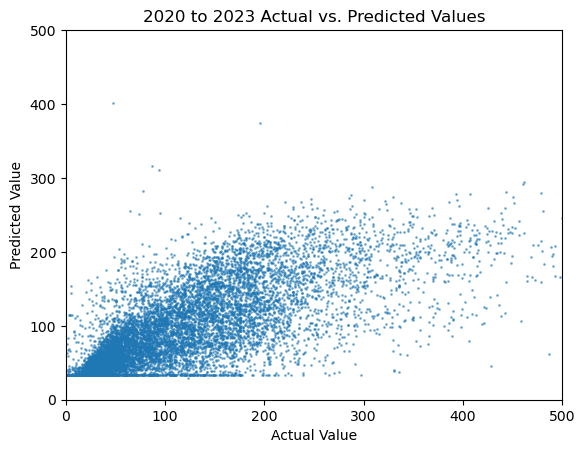

In [93]:
# Scattred plot for ANN predection
plt.scatter(ann_diff['Actual value'], ann_diff['Predicted value'],s=1, alpha=0.5)
x_min=0
x_max=500

y_min=0
y_max=500
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('2020 to 2023 Actual vs. Predicted Values')

# Display the plot
plt.show()

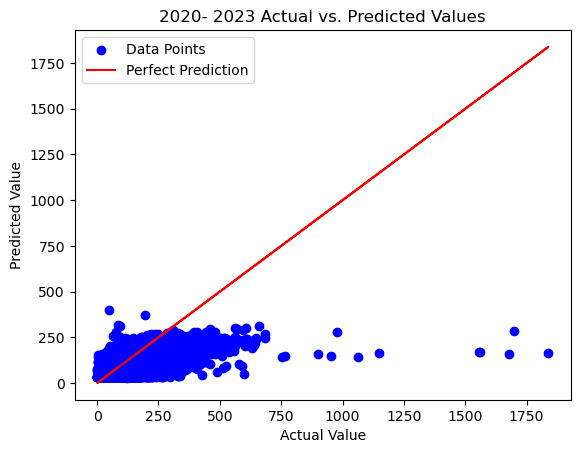

In [99]:
plt.scatter(ann_diff['Actual value'], ann_diff['Predicted value'], color='blue', label='Data Points')
plt.plot(ann_diff['Actual value'], ann_diff['Actual value'], color='red', label='Perfect Prediction')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('2020- 2023 Actual vs. Predicted Values')
plt.legend()
plt.show()

## Three Model Predection Result

In [97]:
print("ANN R-squared:", r2_ann)
print(" ANN R mean square error:", rmse_ann)
print("ANN Mean Squared Error:", mse_rf)
print(" Random forest R-squared:", r2_rf)
print("Random forest Mean Absoult Error:", mae_rf)
print(" Random forest r Mean Squared Error:", rmse_rf)
print("Linear Regression r2 score: %.10f" % r2_score(y_test, y_pred_mlr))

print(" Linear Regression mae : %.10f" % mean_absolute_error(y_test, y_pred_mlr))
print("Linear Regression mse: %.10f" % mean_squared_error(y_test, y_pred_mlr))
print("Linear Regression rmse: %.10f" % mean_squared_error(y_test, y_pred_mlr,squared = False))

ANN R-squared: 0.4122160613351039
 ANN R mean square error: 77.20683901634534
ANN Mean Squared Error: 2039.9647486043264
 Random forest R-squared: 0.7988459257629172
Random forest Mean Absoult Error: 23.888026866713187
 Random forest r Mean Squared Error: 45.165968921349695
Linear Regression r2 score: -0.3879583697
 Linear Regression mae : 84.7661141474
Linear Regression mse: 14075.7086703140
Linear Regression rmse: 118.6410918287
